# Importing of scrapped tweets data from Twint API



In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab Notebooks/

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks


In [2]:
import pandas as pd


# df = pd.read_excel('SGTweets.xlsx')
# xls = pd.ExcelFile('.xls')
df = pd.read_csv('reviews.csv')

In [3]:
df.head(2)

date_of_review              location  ...    date_of_exp helpful_votes
0       Apr 2021     Sydney, Australia  ...     April 2021           NaN
1       Jan 2021  Singapore, Singapore  ...   January 2021           NaN

[2 rows x 6 columns]

In [4]:
df_clean = df

In [5]:
df_clean.head()

type(df_clean)

pandas.core.frame.DataFrame

# Additional Filter by Language Code

In [6]:
is_en = df['language'] == 'en'

print(is_en.head())



KeyError: ignored

In [7]:
df_en = df[is_en]

df_en.shape

NameError: ignored

In [8]:
df.shape

(5, 6)

# Round 1 of Cleaning

In [10]:
import re 
import string
import nltk
import numpy as np
nltk.download('stopwords')

from nltk.corpus import stopwords
stop = stopwords.words('english')

def clean_text_round1(text):
    '''Make text lowercase, remove punctuation and remove words containing numbers.'''
    EMOJI_PATTERN = re.compile(
    "(["
    "\U0001F1E0-\U0001F1FF"  # flags (iOS)
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F680-\U0001F6FF"  # transport & map symbols
    "\U0001F700-\U0001F77F"  # alchemical symbols
    "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
    "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
    "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
    "\U0001FA00-\U0001FA6F"  # Chess Symbols
    "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
    "\U00002702-\U000027B0"  # Dingbats
    "])"
    ) 
    text = text.lower()
    text = re.sub('#\w*', '', text)
    text = re.sub('@\w*', '', text)    
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(EMOJI_PATTERN, '', text)
    text = re.sub('([^\x00-\x7F])+','',text)
    text = ' '.join([word for word in text.split() if word not in (stop)])
    return text

# Let's take a look at the updated text
df_clean = pd.DataFrame(df['review_content'].apply(clean_text_round1))
df_clean.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


review_content
0  first time touring singapore cbd clark quay ri...
1  first experience singapore river cruise tourin...
2  river cruise along singapore river nostalgic s...
3  nice evening activity best river lit doesnt la...
4  singapore attractions cover much singapores pa...

# Removing all the empty texts in cleaned DataFrame for Twitter


In [12]:
import numpy as np
df_clean['review_content'].replace('', np.nan, inplace = True)
df_clean.head()

review_content
0  first time touring singapore cbd clark quay ri...
1  first experience singapore river cruise tourin...
2  river cruise along singapore river nostalgic s...
3  nice evening activity best river lit doesnt la...
4  singapore attractions cover much singapores pa...

In [13]:
df_clean.dropna(subset = ['review_content'], inplace = True)

In [14]:
df_clean.shape

(5, 1)

# Round 2 of Cleaning

In [15]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
def clean_text_round2(text):
    return ' '.join([word for word in text.split() if word not in (stop)])


In [17]:
df_clean = pd.DataFrame(df_clean['review_content'].apply(clean_text_round2))
df_clean.head()


review_content
0  first time touring singapore cbd clark quay ri...
1  first experience singapore river cruise tourin...
2  river cruise along singapore river nostalgic s...
3  nice evening activity best river lit doesnt la...
4  singapore attractions cover much singapores pa...

# Round 3 of Cleaning

In [18]:
# 1. extra cleaning
# Here we will try to do lemmatization instead. 

import nltk
nltk.download('wordnet')
nltk.download('punkt')

from nltk.stem import WordNetLemmatizer 
wordnet_lemmatizer = WordNetLemmatizer()

def clean_text_round3_lemmatize(text):
    
    tokenization = nltk.word_tokenize(text)
    lemmtized_text = " ".join([wordnet_lemmatizer.lemmatize(word) for word in tokenization])
    return lemmtized_text


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [19]:
#  test the function
text = "studies studying cries cry"
clean_text_round3_lemmatize(text)

'study studying cry cry'

In [20]:
df_clean = pd.DataFrame(df_clean['review_content'].apply(clean_text_round3_lemmatize))
df_clean.tail()


review_content
0  first time touring singapore cbd clark quay ri...
1  first experience singapore river cruise tourin...
2  river cruise along singapore river nostalgic s...
3  nice evening activity best river lit doesnt la...
4  singapore attraction cover much singapore past...

In [22]:
# We are going to create a document-term matrix using CountVectorizer, and exclude common English stop words
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english') #You can remove stop words using CountVectorizer as well
data_cv = cv.fit_transform(df_clean['review_content'])
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = df_clean.index
data_dtm.head()


activity  area  attraction  balance  ...  visiting  wait  wind  year
0         0     0           0        0  ...         0     0     0     0
1         0     1           0        1  ...         0     0     1     0
2         0     0           0        0  ...         0     0     0     0
3         1     0           0        0  ...         0     2     0     0
4         0     0           1        0  ...         1     0     0     1

[5 rows x 76 columns]

# Word Cloud for Scrapped Tweets

---



In [23]:
pip install wordcloud

In [24]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [25]:
text_joined = " ".join(one_row for one_row in df_clean['review_content'])

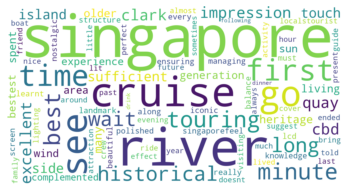

In [26]:
# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white", width=1500, height=800).generate(text_joined)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()



# Vader Sentiment for Twitter Scrapped

In [27]:
!pip install vaderSentiment

     |████████████████████████████████| 125 kB 33.6 MB/s 


In [28]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

In [29]:
df_clean.head()

review_content
0  first time touring singapore cbd clark quay ri...
1  first experience singapore river cruise tourin...
2  river cruise along singapore river nostalgic s...
3  nice evening activity best river lit doesnt la...
4  singapore attraction cover much singapore past...

In [30]:
# 1. Write a python function that returns VADER's 'compound score' of a sentence

def vader_compound_score(sentence): 
    
    sid_obj = SentimentIntensityAnalyzer() 
    sentiment_dict = sid_obj.polarity_scores(sentence)
    
    return sentiment_dict['compound']


In [32]:
# 2. Apply vader_compound_score on data. New column name would be 'vader_sent'

df_clean['vader_sent'] = df_clean['review_content'].apply(vader_compound_score)

df_clean.head()


review_content  vader_sent
0  first time touring singapore cbd clark quay ri...      0.8689
1  first experience singapore river cruise tourin...      0.2732
2  river cruise along singapore river nostalgic s...      0.6369
3  nice evening activity best river lit doesnt la...      0.7906
4  singapore attraction cover much singapore past...      0.8720

# Visualisation of Vader Scores 




Text(0.5, 1.0, 'Vader Sentiment Score of Reviews of Singapore River')

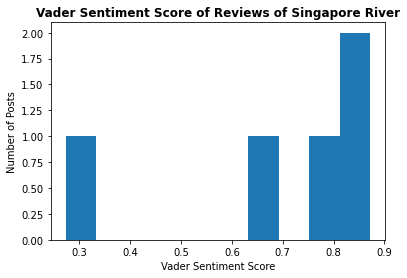

In [33]:
# 4. Plot histogram of vader compound score
plt.hist(df_clean['vader_sent'])
plt.xlabel('Vader Sentiment Score') 
plt.ylabel('Number of Posts')
plt.title('Vader Sentiment Score of Reviews of Singapore River', 
          fontweight ="bold")
#plt.title('Vader Sentiment Score of Tweets Singapore Post Circuit Breaker', 
#          fontweight ="bold")

#plt.savefig("singapore_post_circuit_breaker_twitter_scrapped_vader_score.png")


In [34]:
plt.hist(df_clean['subjectivity'])
plt.xlabel('Subjectivity Score') 
plt.ylabel('Number of Posts') 
plt.title('Subjectivity Score of Tweets Post Circuit Breaker', 
          fontweight ="bold")

plt.savefig("singapore_post_circuit_breaker_scrapped_subjectivity_score.png")

KeyError: ignored

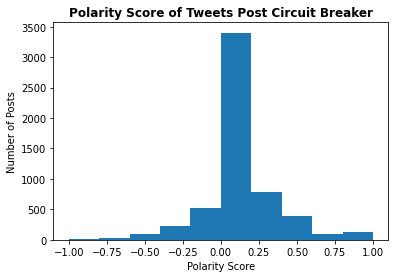

In [ ]:
plt.hist(df_clean['polarity'])
plt.xlabel('Polarity Score') 
plt.ylabel('Number of Posts') 
plt.title('Polarity Score of Tweets Post Circuit Breaker', 
          fontweight ="bold")

plt.savefig("singapore_post_circuit_breaker_scrapped_polarity_score.png")

In [ ]:
df_clean = df_sg

In [ ]:
df_clean.head()

0    0.700000
1    0.487500
2    0.000000
3    0.136364
4    0.378788
Name: textblob score, dtype: float64

# Defining Polarity Class of Vader Sentiment Scores

In [ ]:
df_clean.head()

def polarity_class(x):
    if x == 0:
        return 'Neutral'
    if x > 0:
        return 'Positive'
    if x < 0:
        return 'Negative'


df_clean['Sentiment'] = df_clean['vader_sent'].apply(polarity_class)

In [ ]:
df_clean['Sentiment'].value_counts()

Positive    2828
Neutral     1629
Negative    1033
Name: Sentiment, dtype: int64

In [ ]:
df_clean.head()

tweet  vader_sent Sentiment
1  day mco back normal life tweaking anticipated ...      0.0000   Neutral
2  today last public holiday till july also mco o...      0.7269  Positive
4  mco made realise every moment matter im gon na...      0.2732  Positive
8  esok might last day wfh since mco lifted almos...      0.0000   Neutral
9                         karpal singh jogging track      0.0000   Neutral

# Intermediary Steps (Not important)

In [ ]:
df_clean_dropped_neutral_malaysia.head()

tweet  vader_sent Sentiment
2   today last public holiday till july also mco o...      0.7269  Positive
4   mco made realise every moment matter im gon na...      0.2732  Positive
15  balik kampung balik kampung raya week ago stil...      0.1779  Positive
17  please confirm foreigner expired visa mco stil...      0.3182  Positive
20  record coz dont good memory tukar selipar kuda...     -0.1295  Negative

In [ ]:
df_clean_dropped_neutral_malaysia_2nd.head(3)

tweet  vader_sent Sentiment
2  think past two day ive concalls voice call zoo...     -0.3321  Negative
5  mco like another cmco took one hour get home t...      0.6124  Positive
8                                       top mco mood      0.2023  Positive

In [ ]:
df_clean_dropped_neutral_malaysia_2nd = df_clean_dropped_neutral

df_clean_dropped_neutral_malaysia_2nd.head(2)

tweet  ...         Country
2  think past two day ive concalls voice call zoo...  ...  United Kingdom
5  mco like another cmco took one hour get home t...  ...  United Kingdom

[2 rows x 4 columns]

In [ ]:
df_combine = df_clean_dropped_neutral_malaysia.append(df_clean_dropped_neutral_malaysia_2nd)

In [ ]:
df_combine.head()

tweet  ...   Country
2   today last public holiday till july also mco o...  ...  Malaysia
4   mco made realise every moment matter im gon na...  ...  Malaysia
15  balik kampung balik kampung raya week ago stil...  ...  Malaysia
17  please confirm foreigner expired visa mco stil...  ...  Malaysia
20  record coz dont good memory tukar selipar kuda...  ...  Malaysia

[5 rows x 4 columns]

# Boxplot Distribution of Vader Sentiment Scores


In [ ]:
mid_df_sg = pd.read_csv('df_clean_dropped_neutral_sg.csv')
mid_df_my = pd.read_csv('df_clean_dropped_neutral_my.csv')
mid_df_uk = pd.read_csv('df_clean_dropped_neutral_uk.csv')

mid_df_my['Country'] = 'Malaysia'
mid_df_sg['Country'] = 'Singapore'
mid_df_uk['Country'] = 'United Kingdom'
mid_df_sg.columns = ['Unnamed: 0', 'trans_dest', 'vader_sent', 'Sentiment', 'Country']



# df_combine =  mid_df_my.append(mid_df_sg)

df_combine = df_combine.append(mid_df_uk)


In [ ]:
df_combine.columns

Index(['Unnamed: 0', 'tweet', 'vader_sent', 'Sentiment', 'Country',
       'trans_dest'],
      dtype='object')

In [ ]:
df_combine.columns = ['Unnamed: 0', 'tweet', 'Vader Score', 'Sentiment', 'Country',
       'trans_dest']

In [ ]:
mid_df_sg.columns

Index(['Unnamed: 0', 'trans_dest', 'vader_sent', 'Sentiment', 'Country'], dtype='object')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

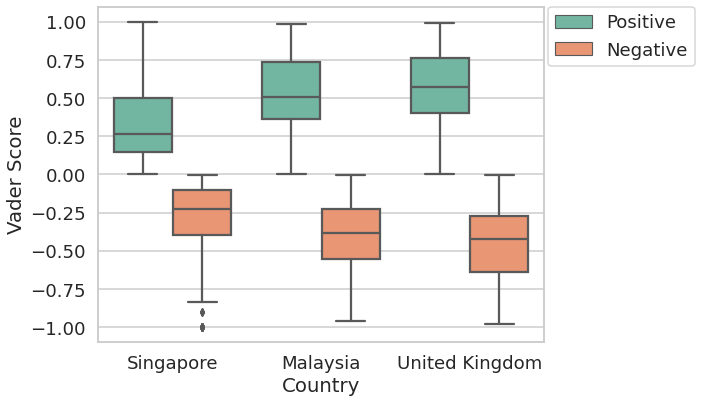

In [ ]:
sns.set_context("talk", font_scale=1.1)
plt.figure(figsize=(10,6))
sns.boxplot(x="Country", 
                y="Vader Score", 
                hue="Sentiment",
                palette = 'Set2',
                order = ['Singapore','Malaysia','United Kingdom'],
                data=df_combine)
plt.xlabel("Country")
plt.ylabel("Vader Score")
# place the legend outside the figure/plot
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
# plt.title("Distribution of ")
plt.tight_layout()
# plt.savefig("place_legend_outside_plot_Seaborn_scatterplot.png",
#                     format='png',dpi=150)

In [ ]:
is_not_Neutral = df_clean['Sentiment'] != 'Neutral'

In [ ]:
df_clean_dropped_neutral = df_clean[is_not_Neutral]

In [ ]:
df_clean_dropped_neutral['Sentiment'].value_counts()

Positive    2828
Negative    1033
Name: Sentiment, dtype: int64

In [ ]:
df_clean_dropped_neutral.to_csv('df_clean_dropped_neutral_my.csv')


# Malaysia Lockdown (Rough working)



In [ ]:
import pandas as pd

# xls = pd.ExcelFile('.xls')
df = pd.read_csv('Malaysia_2nd_Lockdown-Tweets.csv')

In [ ]:
df.head()

id  conversation_id  ... trans_src trans_dest
0  1.359210e+18     1.358830e+18  ...       NaN        NaN
1  1.359190e+18     1.359190e+18  ...       NaN        NaN
2  1.359180e+18     1.359180e+18  ...       NaN        NaN
3  1.359170e+18     1.359170e+18  ...       NaN        NaN
4  1.359170e+18     1.359170e+18  ...       NaN        NaN

[5 rows x 36 columns]

In [ ]:
import re 
import string
import nltk
import numpy as np
nltk.download('stopwords')

from nltk.corpus import stopwords
stop = stopwords.words('english')

def clean_text_round1(text):
    '''Make text lowercase, remove punctuation and remove words containing numbers.'''
    EMOJI_PATTERN = re.compile(
    "(["
    "\U0001F1E0-\U0001F1FF"  # flags (iOS)
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F680-\U0001F6FF"  # transport & map symbols
    "\U0001F700-\U0001F77F"  # alchemical symbols
    "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
    "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
    "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
    "\U0001FA00-\U0001FA6F"  # Chess Symbols
    "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
    "\U00002702-\U000027B0"  # Dingbats
    "])"
    ) 
    text = text.lower()
    text = re.sub('#\w*', '', text)
    text = re.sub('@\w*', '', text)    
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(EMOJI_PATTERN, '', text)
    text = re.sub('([^\x00-\x7F])+','',text)
    text = ' '.join([word for word in text.split() if word not in (stop)])
    return text

# Let's take a look at the updated text
df_clean = pd.DataFrame(df['tweet'].apply(clean_text_round1))
df_clean.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


tweet
0  ngomongin lockdown di tahun covid kayanya udah...
1  mag anniv na ang covid lockdown abs shutdown k...
2                           lock sa feb sarado lahat
3  oo ngaaaaaaaaa remember travelling back manila...
4  awie never getti kalye tunes last year napaka ...

In [ ]:
df_clean['tweet'].replace('', np.nan, inplace = True)
df_clean.head()

tweet
0  ngomongin lockdown di tahun covid kayanya udah...
1  mag anniv na ang covid lockdown abs shutdown k...
2                           lock sa feb sarado lahat
3  oo ngaaaaaaaaa remember travelling back manila...
4  awie never getti kalye tunes last year napaka ...

In [ ]:
df_clean.dropna(subset = ['tweet'], inplace = True)

In [ ]:
df_clean.shape

(1051, 1)

In [ ]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
def clean_text_round2(text):
    return ' '.join([word for word in text.split() if word not in (stop)])
  

In [ ]:
df_clean_malaysia_2nd_lockdown = pd.DataFrame(df_clean['tweet'].apply(clean_text_round2))
df_clean_malaysia_2nd_lockdown.head()


tweet
0  ngomongin lockdown di tahun covid kayanya udah...
1  mag anniv na ang covid lockdown abs shutdown k...
2                           lock sa feb sarado lahat
3  oo ngaaaaaaaaa remember travelling back manila...
4  awie never getti kalye tunes last year napaka ...

In [ ]:
# 1. extra cleaning
# It seemed the review data is quite neat, and there's nothing much to clean... 
# Here we will try to do lemmatization instead. 

import nltk
nltk.download('wordnet')
nltk.download('punkt')

from nltk.stem import WordNetLemmatizer 
wordnet_lemmatizer = WordNetLemmatizer()

def clean_text_round3_lemmatize(text):
    
    tokenization = nltk.word_tokenize(text)
    lemmtized_text = " ".join([wordnet_lemmatizer.lemmatize(word) for word in tokenization])
    return lemmtized_text


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
df_clean_malaysia_2nd_lockdown = pd.DataFrame(df_clean_malaysia_2nd_lockdown['tweet'].apply(clean_text_round3_lemmatize))
df_clean_malaysia_2nd_lockdown.shape


(1051, 1)

In [ ]:
tweet_joined = " ".join(one_row for one_row in df_clean_malaysia_1st_lockdown['tweet'])

# print(tweet_joined)

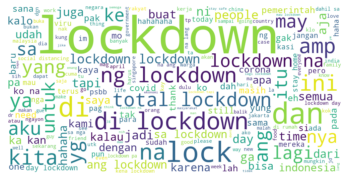

In [ ]:
# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white", width=1000, height=500).generate(tweet_joined)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file("malaysia_2nd_lockdown_word_cloud.png")


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

In [ ]:
def vader_compound_score(sentence): 
    
    sid_obj = SentimentIntensityAnalyzer() 
    sentiment_dict = sid_obj.polarity_scores(sentence)
    
    return sentiment_dict['compound']

In [ ]:
df_clean_malaysia_1st_lockdown['vader_sent'] = df_clean_malaysia_1st_lockdown['tweet'].apply(vader_compound_score)

df_clean_malaysia_1st_lockdown.head()

KeyboardInterrupt: ignored

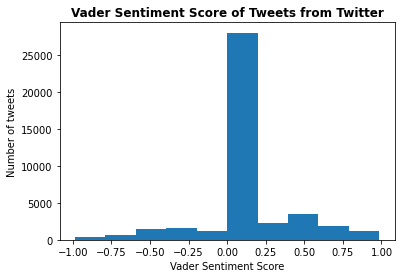

In [ ]:
plt.hist(df_clean_malaysia_1st_lockdown['vader_sent'])
plt.xlabel('Vader Sentiment Score') 
plt.ylabel('Number of tweets') 
plt.title('Vader Sentiment Score of Tweets from Twitter', 
          fontweight ="bold")

plt.savefig("civil_disobedience_twitter_vader_score.png")

In [ ]:
df_clean_malaysia_1st_lockdown.head()

def polarity_class(x):
    if x == 0:
        return 'Neutral'
    if x > 0:
        return 'Positive'
    if x < 0:
        return 'Negative'


df_clean_malaysia_1st_lockdown['Sentiment'] = df_clean_malaysia_1st_lockdown['vader_sent'].apply(polarity_class)

In [ ]:
df_clean_malaysia_1st_lockdown['Sentiment'].value_counts()

Neutral     26995
Positive     9994
Negative     5236
Name: Sentiment, dtype: int64

In [ ]:
import pandas as pd

# xls = pd.ExcelFile('.xls')
df = pd.read_csv('Malaysia_2nd_Lockdown-Tweets.csv')

In [ ]:
df.head()

id  conversation_id  ... trans_src trans_dest
0  1.359210e+18     1.358830e+18  ...       NaN        NaN
1  1.359190e+18     1.359190e+18  ...       NaN        NaN
2  1.359180e+18     1.359180e+18  ...       NaN        NaN
3  1.359170e+18     1.359170e+18  ...       NaN        NaN
4  1.359170e+18     1.359170e+18  ...       NaN        NaN

[5 rows x 36 columns]

In [ ]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
def clean_text_round2(text):
    return ' '.join([word for word in text.split() if word not in (stop)])
  